Gensim has [detailed documentation on word2vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

In [1]:
import gensim
import numpy as np

# Downloading the original word2vec on Google News

It's about 2GB!

In [2]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

## Retrieving Vectors

We can lookup an item directly

In [3]:
wv_doctor = wv['doctor']
type(wv_doctor), wv_doctor.shape

(numpy.ndarray, (300,))

We can also get it's index

In [4]:
idx_doctor = wv.key_to_index['doctor']
idx_doctor

2447

And look it up by index

In [5]:
np.testing.assert_allclose(wv[idx_doctor], wv_doctor)

We can also get from the index back to the word

In [6]:
assert wv.index_to_key[idx_doctor] == 'doctor'

All the vectors are stored in the `vectors` attribute

In [7]:
wv.vectors.shape

(3000000, 300)

In [8]:
np.testing.assert_allclose(wv.vectors[idx_doctor,:], wv_doctor)

If we get something out of the vocabulary we get an error

In [9]:
try:
    wv['covid']
    assert False
except KeyError as e:
    print(e)

"Key 'covid' not present"


In [10]:
try:
    wv.key_to_index['covid']
    assert False
except KeyError as e:
    print(e)

'covid'


The size of the vocabulary is easy to retrieve

In [11]:
vocab_size = len(wv.key_to_index)
vocab_size

3000000

## Similarity

We can get the cosine similarity between words

Because we have a single representation every word is most similar to itself

In [12]:
wv.similarity('apple', 'apple')

1.0

Similarity is a shortcut

In [13]:
wv.similarity('apple', 'pear')

0.64506966

In [14]:
def l2_norm(v):
    return np.sqrt((v**2).sum())

def l2_normalise(v):
    return v / l2_norm(v)

def cosine_distance(v, w):
    return l2_normalise(v) @ l2_normalise(w)

Tests

In [15]:
assert l2_norm(np.array([0,1])) == 1.0

In [16]:
np.testing.assert_allclose(l2_normalise(np.array([0,1])), np.array([0,1]))

In [17]:
np.testing.assert_almost_equal(l2_norm(np.array([3,4])), 5)

In [18]:
np.testing.assert_almost_equal(l2_normalise(np.array([3,4])), np.array([3/5, 4/5]))

In [19]:
np.testing.assert_almost_equal(cosine_distance(np.array([0,1]), np.array([0,1])), 1.)

In [20]:
np.testing.assert_almost_equal(cosine_distance(np.array([0,1]), np.array([1,0])), 0.)

In [21]:
np.testing.assert_almost_equal(cosine_distance(np.array([0,1]), np.array([3/5,4/5])), 4/5)

In [22]:
np.testing.assert_almost_equal(cosine_distance(np.array([0,1]), np.array([3,4])), 4/5)

### Examples

In [23]:
wv.similarity('apple', 'banana')

0.5318406

This is just the cosine distance

In [24]:
cosine_distance(wv['apple'], wv['banana'])

0.53184056

Gensim can precompute the norms in `.norms` so we can skip that step

In [25]:
wv.fill_norms()

In [26]:
wv.norms.shape

(3000000,)

In [27]:
idx_apple = wv.key_to_index['apple']
idx_banana = wv.key_to_index['banana']
np.dot(wv[idx_apple] / wv.norms[idx_apple], wv[idx_banana] / wv.norms[idx_banana])

0.53184056

### Most similar

In [28]:
%%time
wv.most_similar(positive=['apple'], topn=5)

CPU times: user 1.45 s, sys: 466 ms, total: 1.92 s
Wall time: 243 ms


[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127)]

We could do this by brute force

In [29]:
%%time
positive = 'apple'
topn = 5

idx_apple = wv.key_to_index[positive]
apple_norm_vector = wv[idx_apple] / wv.norms[idx_apple]

distances = (wv.vectors @ apple_norm_vector) / (wv.norms)



# Simple solution
#rank = np.argsort(1-distances)[:topn+1]

# This is much faster for small n
rank = np.argpartition(1-distances, topn+1)[:topn+1]
rank = rank[np.argsort(1-distances[rank])]

# We have to do a little bit of fiddling to avoid returning apple itself
result = [(wv.index_to_key[idx], distances[idx]) for idx in rank if idx != idx_apple][:topn]

result

CPU times: user 1.4 s, sys: 249 ms, total: 1.65 s
Wall time: 210 ms


[('apples', 0.72035974),
 ('pear', 0.6450697),
 ('fruit', 0.64101464),
 ('berry', 0.63022953),
 ('pears', 0.61339617)]

For a very fast search we could use an approximate nearest neighbours approach, like in [faiss](https://github.com/facebookresearch/faiss), [annoy](https://github.com/spotify/annoy) and [hnswlib](https://github.com/nmslib/hnswlib).

You can pass an `indexer` to `wv.most_similar` which likely is a similar idea.

#### Multiple words

We can also take multiple words

In [30]:
%%time
wv.most_similar(positive=['apple', 'rhubarb'], topn=5)

CPU times: user 1.3 s, sys: 519 ms, total: 1.82 s
Wall time: 231 ms


[('berry', 0.7345511317253113),
 ('strawberry', 0.7270347476005554),
 ('pear', 0.7135796546936035),
 ('pears', 0.7090939879417419),
 ('blueberry', 0.7078691124916077)]

And we get the same result

In [31]:
%%time
positive = ['apple', 'rhubarb']
topn = 5

total = topn + len(positive)

# Calculate the average vector
indices = [wv.key_to_index[p] for p in positive]
vector = l2_normalise(np.mean((wv[indices].T / wv.norms[indices]), axis=1))

distances = (wv.vectors @ vector) / (wv.norms)

# Simple solution
#rank = np.argsort(1-distances)[:topn+1]

# This is much faster for small n
rank = np.argpartition(1-distances, topn+1)[:total]
rank = rank[np.argsort(1-distances[rank])]

# We have to do a little bit of fiddling to avoid returning apple itself
result = [(wv.index_to_key[idx], distances[idx]) for idx in rank if idx not in indices][:topn]

result

CPU times: user 1.39 s, sys: 340 ms, total: 1.73 s
Wall time: 220 ms


[('berry', 0.73455113),
 ('strawberry', 0.72703475),
 ('pear', 0.71357954),
 ('pears', 0.709094),
 ('blueberry', 0.70786905)]

#### Negatives
We can also add negative using a negative weight (-1.0).

An apple that's not a fruit is the brand Apple

In [32]:
%%time
wv.most_similar(positive=['apple'], negative=['fruit'], topn=5)

CPU times: user 1.36 s, sys: 278 ms, total: 1.64 s
Wall time: 209 ms


[('Apple', 0.33312755823135376),
 ('Appleâ_€_™', 0.3215164244174957),
 ('Ipod', 0.31791260838508606),
 ('designer_Jonathan_Ive', 0.31394994258880615),
 ('ipod', 0.30566027760505676)]

### Doesn't match

In [33]:
wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])

'car'

I would naively look for the word furthest from the centre

In [34]:
words = ['fire', 'water', 'land', 'sea', 'air', 'car']

In [35]:
vectors = [l2_normalise(wv[w]) for w in words]

In [36]:
mean_vector = l2_normalise(np.mean(vectors, axis=0))

In [37]:
distances = [cosine_distance(v, mean_vector) for v in vectors]
distances

[0.5159994, 0.70721567, 0.58156997, 0.63775754, 0.6186152, 0.45616907]

In [38]:
words[np.argmin(distances)]

'car'

Looking at the source this is what it does; it calls `rank_by_centrality`

### Analogies

boy is to man as ___ is to girl

In [39]:
wv.most_similar(positive=['man', 'girl'], negative=['boy'], topn=3)

[('woman', 0.8713073134422302),
 ('teenage_girl', 0.6854888200759888),
 ('lady', 0.5916110873222351)]

In [40]:
wv.most_similar(positive=['cat', 'dog'], negative=['kitten'], topn=3)

[('dogs', 0.7362095713615417),
 ('cats', 0.6359845995903015),
 ('beagle', 0.6304870247840881)]

Why only positive / negative weights?

Could we look at all the stages between `man` and `boy`?

In [41]:
start = 'baby'
end = 'adult'
delta = wv[end] - wv[start]

In [42]:
dists = (wv.vectors @ l2_normalise(wv[start] + 1 * delta)) / wv.norms
idxs = np.argsort(1-dists)[:2]
[wv.index_to_key[i] for i in idxs]

['adult', 'Adult']

In [43]:
dists = (wv.vectors @ l2_normalise(wv[start] + 0. * delta)) / wv.norms
idxs = np.argsort(1-dists)[:2]
[wv.index_to_key[i] for i in idxs]

['baby', 'newborn']

In [44]:
dists = (wv.vectors @ l2_normalise(wv[start] + 0.7 * delta)) / wv.norms
idxs = np.argsort(1-dists)[:2]
[wv.index_to_key[i] for i in idxs]

['adult', 'infant']

## Evaluation

In [45]:
%%time
from gensim.test.utils import datapath
score, results = wv.evaluate_word_analogies(datapath('questions-words.txt'))

CPU times: user 44min 59s, sys: 10min 30s, total: 55min 30s
Wall time: 6min 58s


In [46]:
print(score)
for s in results:
    print(f"{s['section']:40s} {len(s['correct']):02}/{len(s['incorrect']+s['correct']):04}")

0.7401448525607863
capital-common-countries                 421/0506
capital-world                            3552/4368
currency                                 230/0808
city-in-state                            1779/2467
family                                   436/0506
gram1-adjective-to-adverb                290/0992
gram2-opposite                           353/0812
gram3-comparative                        1216/1332
gram4-superlative                        987/1122
gram5-present-participle                 829/1056
gram6-nationality-adjective              1442/1599
gram7-past-tense                         1020/1560
gram8-plural                             1159/1332
gram9-plural-verbs                       593/0870
Total accuracy                           14307/19330


In [47]:
wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

((0.6238773466616107, 1.7963237724171284e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)

## Plotting

This is taken from the lesson Demo

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

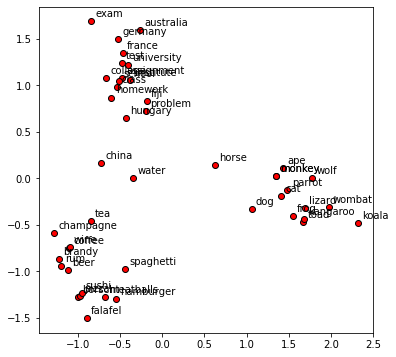

In [49]:
display_pca_scatterplot(wv, words=['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

## Cleanup

In [50]:
del wv

# Using Glove Vectors


Let's represent the information of word vectors in [Glove homepage](https://nlp.stanford.edu/projects/glove/)


In [51]:
glove_data_sources = {
    '6B': {
        'name': 'glove.6B',
        'source': 'Wikipedia 2014 + Gigaword 5',
        'tokens': 6e9,
        'vocab': 400e3,
        'cased': False,
        'dimensions': [50, 100, 200, 300],
        'size_mb': 822,
        'url': 'https://nlp.stanford.edu/data/glove.6B.zip'
    },
    '42B': {
        'name': 'glove.42B',
        'source': 'Common Crawl',
         'tokens': 42e9,
         'vocab': 1.9e6,
         'cased': False,
         'dimensions': [300],
         'size_mb': 1750,
         'url': 'https://nlp.stanford.edu/data/glove.42B.300d.zip'
    },
    '840B': {
        'name': 'glove.840B',
         'source': 'Common Crawl',
         'tokens': 42e9,
         'vocab': 2.2e6,
         'cased': True,
         'dimensions': [300],
         'size_mb': 2030,
         'url': 'https://nlp.stanford.edu/data/glove.840B.300d.zip'
    },
    'twitter': {
        'name': 'glove.twitter.27B',
            'source': 'Twitter',
         'tokens': 27e9,
         'vocab': 1.2e6,
         'cased': False,
         'dimensions': [25, 50, 100, 200],
         'size_mb': 1420,
         'url': 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'
    },
}

Ported from the documentation of gensim.scripts.glove2word2vec 

In [52]:
from tqdm.auto import tqdm

class TqdmHook(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize

In [53]:
from urllib.request import urlretrieve
from pathlib import Path


DATA = Path('data')
DATA.mkdir(exist_ok=True)

def fetch(url: str, filename: str=None, directory: Path=DATA, force: bool=False) -> Path:
    if filename is None:
        filename = url.split('/')[-1]
    
    dest = directory / filename
    if force or not dest.exists():
        with TqdmHook(unit = 'B', unit_scale = True, unit_divisor = 1024, miniters = 1, desc = filename) as report:
            urlretrieve(url, dest, reporthook=report.update_to)
    
    return dest

In [54]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Load a glove vector, downloading, unzipping and converting as necessary.

In [55]:
from gensim.scripts.glove2word2vec import glove2word2vec
from zipfile import ZipFile
from gensim.models.keyedvectors import KeyedVectors

def load_glove_model(model_name: str, dimension: int, data_dir: Path = DATA, force: bool = False) -> KeyedVectors:
    if model_name not in glove_data_sources:
        raise ValueError(f'Unknown model {model_name}; expected one of {list(glove_data_sources)}')
    metadata = glove_data_sources[model_name]
    if dimension not in metadata['dimensions']:
        raise ValueError(f'Unknown dimension {dimension}; expected one of {metadata["dimensions"]}')
    
    
    w2v_filename = f"{metadata['name']}.{dimension}d.w2v"
    w2v_path = data_dir / w2v_filename
    
    if force or not w2v_path.exists():
        logging.info('Fetching zipfile')
        zipfile_path = fetch(metadata['url'], directory=data_dir, force=force)
        
        # Should be function
        glove_filename = f"{metadata['name']}.{dimension}d.txt"
        glove_path = data_dir / glove_filename
        if force or not glove_path.exists():
            logging.info('Unzipping')
            with ZipFile(zipfile_path) as z:
                z.extract(glove_filename, data_dir)
        
        logging.info('Converting to Word2Vec Format')
        glove2word2vec(glove_path, w2v_path)
    
    model = KeyedVectors.load_word2vec_format(w2v_path)
    return model

In [56]:
%%time
model = load_glove_model('6B', 100)

CPU times: user 19.5 s, sys: 416 ms, total: 19.9 s
Wall time: 19.7 s


In [57]:
def analogy(model, a, is_to, as_a, topn=3):
    return model.most_similar(positive= [as_a, is_to], negative=[a], topn=topn)

In [58]:
analogy(model, 'japan', 'japanese', 'australia')

[('australian', 0.8923497796058655),
 ('zealand', 0.8012940883636475),
 ('british', 0.7840811610221863)]

In [59]:
analogy(model, 'man', 'king', 'woman')

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473)]

In [60]:
analogy(model, a='man', is_to='boy', as_a='woman')

[('girl', 0.9095936417579651),
 ('mother', 0.7666921019554138),
 ('child', 0.7420270442962646)]

In [61]:
analogy(model, a='running', is_to='run', as_a='jumping')

[('jump', 0.6365668773651123),
 ('skate', 0.5734996199607849),
 ('diving', 0.5720967054367065)]

So close

In [62]:
analogy(model, a='dog', is_to='puppy', as_a='cat')

[('puppies', 0.6867596507072449),
 ('kitten', 0.6866797208786011),
 ('kittens', 0.6383703947067261)]

In [63]:
analogy(model, a='dog', is_to='puppy', as_a='horse')

[('gelding', 0.6561240553855896),
 ('filly', 0.6192689538002014),
 ('horses', 0.6143808364868164)]

In [64]:
analogy(model, a='dog', is_to='puppy', as_a='sheep')

[('goats', 0.7177532911300659),
 ('cows', 0.7116653323173523),
 ('calves', 0.6669469475746155)]

Plurals!

In [65]:
analogy(model, a='dog', is_to='dogs', as_a='cat')

[('cats', 0.870152473449707),
 ('animals', 0.7340957522392273),
 ('rabbits', 0.7251664996147156)]

In [66]:
analogy(model, a='dog', is_to='dogs', as_a='mouse')

[('mice', 0.7820927500724792),
 ('rabbits', 0.7002912163734436),
 ('rodents', 0.6620580554008484)]

In [67]:
analogy(model, a='mouse', is_to='mice', as_a='dog')

[('dogs', 0.8047526478767395),
 ('rats', 0.7037932872772217),
 ('cats', 0.6896343231201172)]

In [68]:
analogy(model, a='dog', is_to='dogs', as_a='goose')

[('geese', 0.6569846868515015),
 ('turkeys', 0.6174508929252625),
 ('elk', 0.5829428434371948)]

In [69]:
analogy(model, a='saw', is_to='seen', as_a='ate')

[('eaten', 0.7870859503746033),
 ('eat', 0.7161226272583008),
 ('eats', 0.7083176970481873)]

In [70]:
analogy(model, a='australia', is_to='aboriginal', as_a='canada')

[('inuit', 0.7059606313705444),
 ('métis', 0.6332137584686279),
 ('indigenous', 0.5787938237190247)]

By construction it won't work on self-plurals...

In [71]:
analogy(model, a='dog', is_to='dogs', as_a='fish')

[('birds', 0.7144117951393127),
 ('animals', 0.7041971683502197),
 ('shrimp', 0.669943630695343)]

This is pretty clever

In [72]:
analogy(model, a='france', is_to='french', as_a='netherlands')

[('dutch', 0.8915837407112122),
 ('belgian', 0.7331493496894836),
 ('swedish', 0.7199690937995911)]

Poor has a couple of meanings; I was thinking of poverty, but the analogy here is good.

In [73]:
analogy(model, a='bad', is_to='good', as_a='poor')

[('better', 0.7286986708641052),
 ('excellent', 0.7133066058158875),
 ('improve', 0.6775092482566833)]

In [74]:
analogy(model, a='bad', is_to='good', as_a='poverty')

[('prosperity', 0.6790876984596252),
 ('sustainable', 0.6570262312889099),
 ('literacy', 0.6219431161880493)]

In [75]:
analogy(model, a='good', is_to='bad', as_a='smart')

[('stupid', 0.6949706077575684),
 ('dumb', 0.661355197429657),
 ('nasty', 0.6165375113487244)]

Curious

In [76]:
analogy(model, a='good', is_to='bad', as_a='beautiful')

[('gorgeous', 0.7169793248176575),
 ('lovely', 0.6776781678199768),
 ('ugly', 0.6571363806724548)]

In [77]:
analogy(model, a='good', is_to='bad', as_a='pretty')

[('ugly', 0.7084827423095703),
 ('worse', 0.706501305103302),
 ('crazy', 0.7044617533683777)]

Can't really do collective nouns?
There's a lot of linguistic ambiguity.

In [78]:
analogy(model, a='fish', is_to='school', as_a='geese')

[('elementary', 0.5957281589508057),
 ('morehouse', 0.5584497451782227),
 ('lawrenceville', 0.529654324054718)]

In [79]:
analogy(model, a='birds', is_to='flock', as_a='fish')

[('seafood', 0.571368396282196),
 ('eat', 0.5494017004966736),
 ('shrimp', 0.540702223777771)]

In [80]:
analogy(model, a='ant', is_to='colony', as_a='bird')

[('mainland', 0.6377466320991516),
 ('hong', 0.6355780959129333),
 ('kong', 0.6324601173400879)]

In [81]:
analogy(model, a='whale', is_to='gam', as_a='bird')

[('maoist', 0.5558085441589355),
 ('fnl', 0.5512718558311462),
 ('lra', 0.5276084542274475)]

## Larger model - Trained on Common Crawl

In [82]:
%%time
model = load_glove_model('42B', 300)

CPU times: user 5min 47s, sys: 7.76 s, total: 5min 55s
Wall time: 5min 52s


In [83]:
analogy(model, a='mouse', is_to='mice', as_a='cat')

[('cats', 0.7431511282920837),
 ('dogs', 0.6465448141098022),
 ('kittens', 0.5902024507522583)]

In [84]:
analogy(model, a='dog', is_to='dogs', as_a='cat')

[('cats', 0.9028548002243042),
 ('kittens', 0.6927394270896912),
 ('pets', 0.6669827103614807)]

Or age

In [85]:
analogy(model, a='man', is_to='boy', as_a='woman')

[('girl', 0.8489392995834351),
 ('girls', 0.7242658734321594),
 ('daughter', 0.6717755198478699)]

In [86]:
analogy(model, a='run', is_to='runner', as_a='jump')

[('jumping', 0.5270168781280518),
 ('jumps', 0.5087668895721436),
 ('runners', 0.4657614827156067)]

In [87]:
analogy(model, a='australia', is_to='canberra', as_a='germany')

[('munich', 0.6608784198760986),
 ('berlin', 0.6464670896530151),
 ('stuttgart', 0.6257511973381042)]

In [88]:
analogy(model, a='australia', is_to='beer', as_a='france')

[('beers', 0.552153468132019),
 ('french', 0.527330219745636),
 ('wine', 0.4995618164539337)]